# Getting Started
Let's begin by getting familiar with some of the relevant algorithms and datasets that we could use in the paper.
- [ ] Find several classic timeseries datasets: sunspots, stock prices, streamflow from the Mississippi River would all be fine, but bonus points if you find (or simulate) something more humerous.
- [ ] Try out several seasonal trend decompositions: STL, STR as example
- [ ] Try out fft and clipping out different `bands` from the frequency domain
- [ ] Put those pieces together to define a function for STF: seasonal-trend decomposition using the Fast-Fourier transform.

Good luck!

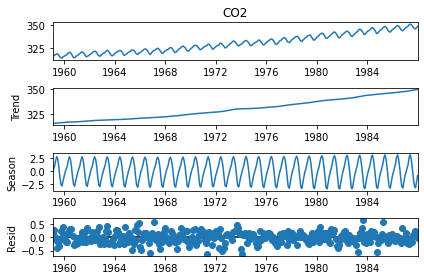

In [31]:
# https://www.statsmodels.org/dev/examples/notebooks/generated/stl_decomposition.html
import pandas as pd
from statsmodels.tsa.seasonal import STL

co2 =pd.read_csv('../data/co2.csv', index_col='date', parse_dates=True, squeeze=True)

stl = STL(co2, seasonal=13)
res = stl.fit()
fig = res.plot()